<a href="https://mingxia.web.unc.edu/" target="_parent"><img src="https://mingxia.web.unc.edu/wp-content/uploads/sites/12411/2020/12/logo_MagicLab-horizontal-4.png" alt="MAGIC Lab"/></a>

# **AntiArtifactsTraining_MRART**
---

**Loading required libraries**
---

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
import sys, argparse
import enum
import time
import datetime
import random
import json
import multiprocessing
import os.path as osp
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
import pylab as pl
import logging
import shutil
import tempfile
import gzip
from typing import Optional, Sequence, Tuple, Union
from urllib.request import urlretrieve
from PIL import Image

from pathlib import Path
from scipy import stats
from IPython import display
from tqdm import trange, tqdm

import copy
import pprint
import torchio as tio
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import L1Loss
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
import tensorboardX

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, roc_auc_score, matthews_corrcoef
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.manifold import TSNE
from sklearn import svm

import monai
import monai.transforms as mt
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset, ImageDataset
from monai.networks.nets import VarAutoEncoder,ViTAutoEnc, AutoEncoder
from monai.networks.layers.convutils import calculate_out_shape, same_padding
from monai.networks.layers.factories import Act, Norm
from monai.networks.utils import one_hot
from monai.utils import set_determinism, first
from monai.utils.enums import MetricReduction
from monai.metrics import compute_hausdorff_distance, HausdorffDistanceMetric
from monai.losses import ContrastiveLoss, DiceLoss, DiceCELoss
from monai.transforms import (
    ConvertToMultiChannelBasedOnBratsClasses,
    AsDiscrete,
    AsDiscreted,
    Activations,
    AddChannelD,
    Compose,
    LoadImageD,
    LoadImaged,
    ScaleIntensityD,
    EnsureTypeD,
    EnsureChannelFirstd,
    LoadImaged,
    Compose,
    CropForegroundd,
    CopyItemsd,
    SpatialPadd,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Orientationd,
    OneOf,
    ScaleIntensityRanged,
    RandSpatialCropSamplesd,
    RandCoarseDropoutd,
    RandCoarseShuffled,
    RandSpatialCrop,#(roi_size, max_roi_size=None, random_center=True, random_size=True, lazy=False)
    RandCropByPosNegLabeld,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet,BasicUNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract

torch.manual_seed(0)
# Set Determinism
set_determinism(seed=0)

pin_memory = torch.cuda.is_available()
#pin_memory = False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

C:\Users\zhlt1\.conda\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Global Setting**
---

In [2]:
logdir_path = './PretrainedModels/'
if os.path.exists(logdir_path)==False:
    os.mkdir(logdir_path)

**File scanner**
---

In [2]:
class ScanFile(object):
    def __init__(self, directory, prefix=None, postfix=None):
        self.directory = directory
        self.prefix = prefix
        self.postfix = postfix

    def scan_files(self):
        files_list = []

        for dirpath, dirnames, filenames in os.walk(self.directory):
            ''''' 
            dirpath is a string, the path to the directory.   
            dirnames is a list of the names of the subdirectories in dirpath (excluding '.' and '..'). 
            filenames is a list of the names of the non-directory files in dirpath. 
            '''
            for special_file in filenames:
                if self.postfix:
                    if special_file.endswith(self.postfix):
                        files_list.append(os.path.join(dirpath, special_file))
                elif self.prefix:
                    if special_file.startswith(self.prefix):
                        files_list.append(os.path.join(dirpath, special_file))
                else:
                    files_list.append(os.path.join(dirpath, special_file))

        return files_list

    def scan_subdir(self):
        subdir_list = []
        for dirpath, dirnames, files in os.walk(self.directory):
            subdir_list.append(dirpath)
        return subdir_list

**Preparing for data reading from MR-ART**
---

In [3]:
MR_ART_dir_out = './SampleData/MRART/'
scan1 = ScanFile(MR_ART_dir_out, postfix='standard_T1w_brain_176_216_176.nii.gz')
scan2 = ScanFile(MR_ART_dir_out, postfix='headmotion1_T1w_brain_dof6_176_216_176.nii.gz')
scan3 = ScanFile(MR_ART_dir_out, postfix='headmotion2_T1w_brain_dof6_176_216_176.nii.gz')

mri_list1  = sorted(scan1.scan_files())
mri_list2  = sorted(scan2.scan_files())
mri_list3  = sorted(scan3.scan_files())
print('standard_MRI_Number:'+str(len(mri_list1))+'  headmotion1_Number:'+str(len(mri_list2))+'  headmotion2_Number:'+str(len(mri_list3)))

filepath = mri_list1[0]
print('filepath:'+filepath)
MRIf_first = nib.load(filepath)
#image_data = MRIf_first.get_fdata()
#image_head = MRIf_first.header

vol_size  = (MRIf_first.header['dim'][1:4])
pix_space = (MRIf_first.header['pixdim'][1:4])
print(vol_size)

MRI_dict_list = []
for item1,item2,item3 in zip(mri_list1,mri_list2,mri_list3):
    MRI_dict_list.append({'mristd':item1,'headmotion':item2})
    MRI_dict_list.append({'mristd':item1,'headmotion':item3})

MRI_list = MRI_dict_list

test_number  = int(len(MRI_list)*0.2)
train_number = int((len(MRI_list)-test_number)*1.0)
print('train_number:'+str(train_number))
print('test_number:'+str(test_number))

train_files = MRI_list[0:train_number]
test_files  = MRI_list[-test_number:]
print(train_files[-2])
print(train_files[-1])
random.shuffle(train_files)


standard_MRI_Number:6  headmotion1_Number:6  headmotion2_Number:6
filepath:./SampleData/MRART/sub-000103_acq-standard_T1w_brain_176_216_176.nii.gz
[176 216 176]
train_number:10
test_number:2
{'mristd': './SampleData/MRART/sub-000175_acq-standard_T1w_brain_176_216_176.nii.gz', 'headmotion': './SampleData/MRART/sub-000175_acq-headmotion1_T1w_brain_dof6_176_216_176.nii.gz'}
{'mristd': './SampleData/MRART/sub-000175_acq-standard_T1w_brain_176_216_176.nii.gz', 'headmotion': './SampleData/MRART/sub-000175_acq-headmotion2_T1w_brain_dof6_176_216_176.nii.gz'}


**Data Loader**
---

In [4]:
train_transforms = Compose(
    [
        mt.LoadImaged(keys=['mristd', 'headmotion'], ensure_channel_first=True, image_only=True),
        mt.ScaleIntensityRangePercentilesd(keys=['mristd', 'headmotion'],lower=0, upper=98, b_min=0., b_max=1.0, clip=True),
        mt.RandSpatialCropd(keys=['mristd', 'headmotion'],roi_size=128, random_size=False),
        mt.RandFlipd(keys=['mristd', 'headmotion'], prob=0.3, spatial_axis=None, lazy=False),
    ]
)
batchsize = 2
train_ds = Dataset(data=train_files, transform=train_transforms)
loader_train = DataLoader(train_ds, batch_size=batchsize, shuffle=True)

{'mristd': './SampleData/MRART/sub-000159_acq-standard_T1w_brain_176_216_176.nii.gz', 'headmotion': './SampleData/MRART/sub-000159_acq-headmotion2_T1w_brain_dof6_176_216_176.nii.gz'}
check_data shape: torch.Size([2, 1, 128, 128, 128])
check_data shape: torch.Size([2, 1, 128, 128, 128])
res mean: -1.0174971976084635e-09
image shape: torch.Size([128, 128, 128])


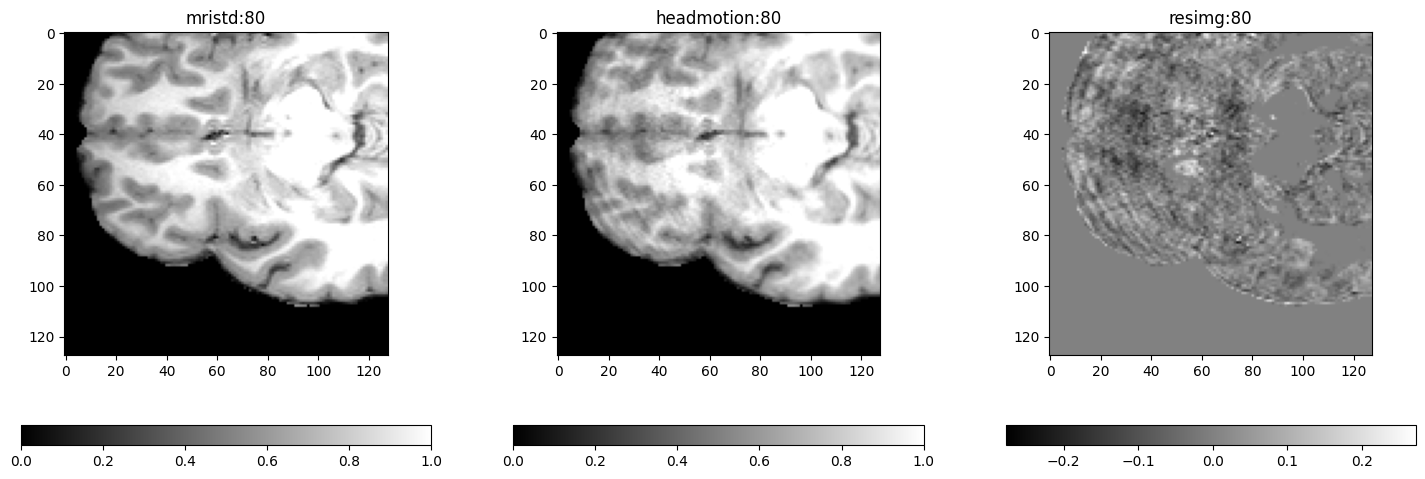

In [5]:
slicez = 64+16
print(train_files[0])
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=2)
check_data = first(check_loader)
#print(check_data)
print(f"check_data shape: {check_data['mristd'].shape}")
print(f"check_data shape: {check_data['headmotion'].shape}")
image0 = check_data['mristd'][0][0]
image1 = check_data['headmotion'][0][0]
imageres = image1-image0
imageres = imageres-np.mean(imageres)
print(f"res mean: {np.mean(imageres)}")
print(f"image shape: {image0.shape}")
# plot the slice [:, :, 80]
fig, axes = plt.subplots(1, 3, figsize=(3*6, 6))
im = axes[0].imshow(image0[:, :, slicez], cmap="gray")
cbar = fig.colorbar(im, ax=axes[0], orientation='horizontal')
axes[0].set_title('mristd:'+str(slicez))
axes[0].grid(visible=False)

im = axes[1].imshow(image1[:, :, slicez], cmap="gray")
cbar = fig.colorbar(im, ax=axes[1], orientation='horizontal')
axes[1].set_title('headmotion:'+str(slicez))
axes[1].grid(visible=False)

im = axes[2].imshow(imageres[:, :, slicez], cmap="gray")
cbar = fig.colorbar(im, ax=axes[2], orientation='horizontal')
axes[2].set_title('resimg:'+str(slicez))
axes[2].grid(visible=False)

plt.show()

**Model definition**
---

In [7]:
from models import AntiART_UNet

MILESTONE = 50
NUM_EPOCHS = MILESTONE*3
LEARNING_RATE = 5e-3
LEARNING_RATE_DECAY = 0.1

OUT_DIR = logdir_path
RESUME_CHP_DIR = logdir_path
summary_path = os.path.join(logdir_path, 'tensorboard')

scorenet = AntiART_UNet(spatial_dims=3, in_channels=1, out_channels=1, features=(16, 32, 64, 128, 128, 16), norm='batch',upsample='nontrainable')
scorenet = scorenet.to(device)
optimizer = torch.optim.Adam(scorenet.parameters(), lr=LEARNING_RATE, weight_decay=0.000, betas=(0.9, 0.999), amsgrad=False)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, list(range(MILESTONE, NUM_EPOCHS, MILESTONE)), gamma = LEARNING_RATE_DECAY)

   
L1Loss  = torch.nn.L1Loss(reduction='mean')
MSELoss = torch.nn.MSELoss(reduction='mean')
BCELoss = torch.nn.BCELoss(reduction='sum')
SSIMLoss= monai.losses.SSIMLoss(spatial_dims=3)

fSSIM   = monai.metrics.regression.SSIMMetric(spatial_dims=3, data_range=1.0)
fMSSSIM = monai.metrics.MultiScaleSSIMMetric(spatial_dims=3, data_range=1.0, kernel_size=7)
fPSNR   = monai.metrics.PSNRMetric(max_val=1.0, reduction=MetricReduction.MEAN, get_not_nans=False)
fRMSE   = monai.metrics.RMSEMetric(reduction=MetricReduction.MEAN, get_not_nans=False)

def torch_gradmap(img):
    #img=torch.nn.functional.pad(img, (1,0,1,0,1,0), "constant", 0) 
    dh = img[:,:,:,:,1:] - img[:,:,:,:,:-1]
    dw = img[:,:,:,1:,:] - img[:,:,:,:-1,:]
    dz = img[:,:,1:,:,:] - img[:,:,:-1,:,:]
    gra_map = (dh[:,:,1:, 1:, :] + dw[:,:,1:,:,1:] + dz[:,:,:,1:,1:])/3.
    gra_map=torch.nn.functional.pad(gra_map, (1,0,1,0,1,0), "constant", 0) 
    return gra_map
def torch_std_estimate(img):
    dh = img[:,:,:,:,1:] - img[:,:,:,:,:-1]
    dw = img[:,:,:,1:,:] - img[:,:,:,:-1,:]
    dz = img[:,:,1:,:,:] - img[:,:,:-1,:,:]
    gra_map = (dh[:,:,1:, 1:, :] + dw[:,:,1:,:,1:] + dz[:,:,:,1:,1:])/3.
    gra_std = torch.std(gra_map, dim=(-1,-2,-3), keepdim=True)   
    return gra_std

BasicUNet features: (16, 32, 64, 128, 128, 16).


**Training Function**
---

In [8]:
max_sigma = 0.3
step = 1
epoch_start = 0

print(str(epoch_start)+':'+str(NUM_EPOCHS))
for epoch in range(epoch_start, NUM_EPOCHS): 
    print(epoch)
    avg_loss = 0  
    with tqdm(total=len(loader_train), desc='Epoch: [%d/%d], lr: [%.6f]'%\
        (epoch+1, NUM_EPOCHS, optimizer.param_groups[0]["lr"]), miniters=1) as t:
        for i, (batch) in enumerate(loader_train):
            scorenet.train()
            scorenet.zero_grad()
            optimizer.zero_grad()

            image_target = batch['mristd'].to(device).float()
            perturbed_samples = samples      = batch['headmotion'].to(device).float()

            perturbed_samples = perturbed_samples*255
            target = image_target*255
            scores,scores_down = scorenet(perturbed_samples)
            
            loss_target       = L1Loss(target,scores)
            loss_grad         = L1Loss(torch_gradmap(target),torch_gradmap(scores))*20
            
            loss = loss_target+loss_grad
            loss.backward()
            optimizer.step()

            denoised = scores/255

            avg_loss += loss.item()

            batch_psnr = 0
            with torch.no_grad():
                batch_psnr = fPSNR(image_target.as_tensor(), denoised.as_tensor())
                batch_ssim = fSSIM(image_target.as_tensor(), denoised.as_tensor())
                batch_psnr = torch.mean(batch_psnr).item()

            t.set_postfix_str("Batch Loss: %.4f, loss_target: %.4f, grad Loss: %.4f, Batch PSNR: %.4f, average loss: %.4f" % (loss.item(),loss_target.item(),loss_grad.item(), batch_psnr,  avg_loss/(i+1)))
            t.update()
            step += 1
            # break

        scheduler.step() 
        if (epoch+1)%MILESTONE==0:
            checkpoint_path = os.path.join(OUT_DIR, f'AntiArtNet_l1loss_epoch%i.pth'% (epoch+1))
            chp = {
                'epoch': epoch, 
                'weights': scorenet.state_dict(),
                'optimizer': optimizer.state_dict()
                }
            torch.save(chp, checkpoint_path)
            print(checkpoint_path)


0:150
0


Epoch: [1/150], lr: [0.005000]: 100%|██████████| 5/5 [00:40<00:00,  8.10s/it, Batch Loss: 158.8044, loss_target: 81.3298, grad Loss: 77.4746, Batch PSNR: 6.1076, average loss: 194.2603]  


1


Epoch: [2/150], lr: [0.005000]: 100%|██████████| 5/5 [00:25<00:00,  5.17s/it, Batch Loss: 158.7201, loss_target: 76.6294, grad Loss: 82.0907, Batch PSNR: 6.4710, average loss: 191.6960] 


2


Epoch: [3/150], lr: [0.005000]: 100%|██████████| 5/5 [00:25<00:00,  5.18s/it, Batch Loss: 189.8828, loss_target: 93.5404, grad Loss: 96.3424, Batch PSNR: 5.4657, average loss: 206.6988]  


3


Epoch: [4/150], lr: [0.005000]:   0%|          | 0/5 [00:05<?, ?it/s]


KeyboardInterrupt: 

**Test--prepare data**
---

In [9]:
test_transforms = Compose(
    [
        mt.LoadImaged(keys=['mristd', 'headmotion'], ensure_channel_first=True, image_only=True),
        mt.ScaleIntensityRangePercentilesd(keys=['mristd', 'headmotion'],lower=0, upper=98, b_min=0., b_max=1.0, clip=True),
        mt.CropForegroundd(keys=['mristd', 'headmotion'], source_key="mristd", mode='empty'),
        mt.DivisiblePadd(keys=['mristd', 'headmotion'],k=16),
    ]
)
test_ds = Dataset(data=test_files, transform=test_transforms)
loader_test = DataLoader(test_ds, batch_size=1)

check_data = first(loader_test)
print(f"check_data shape: {check_data['mristd'].shape}")
print(f"check_data shape: {check_data['headmotion'].shape}")

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.3.


check_data shape: torch.Size([1, 1, 144, 176, 160])
check_data shape: torch.Size([1, 1, 144, 176, 160])


check_data shape: torch.Size([1, 1, 144, 176, 160])
check_data shape: torch.Size([1, 1, 144, 176, 160])
image shape: torch.Size([144, 176, 160])


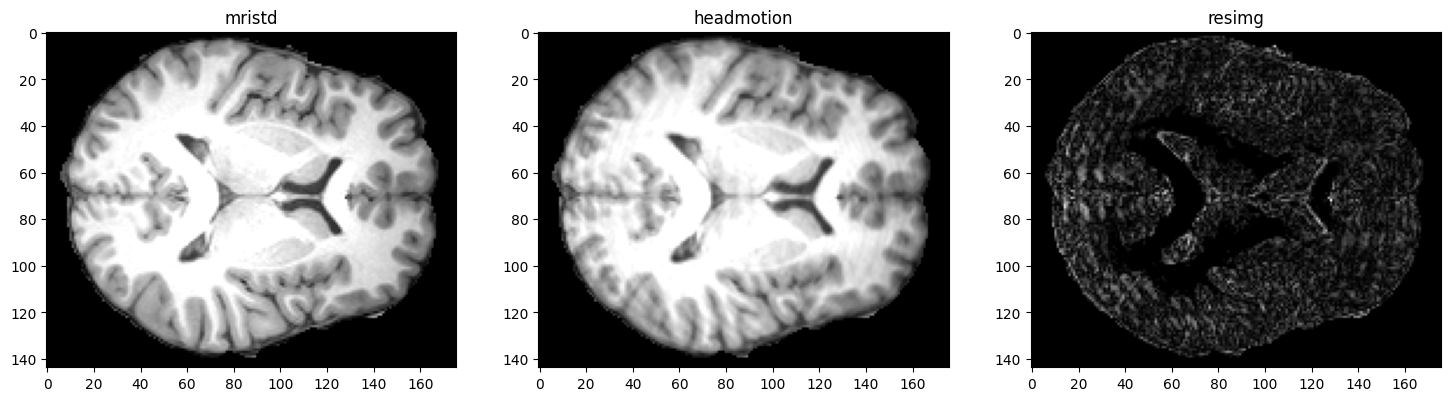

In [10]:
slceZ = 84
#print(check_data)
print(f"check_data shape: {check_data['mristd'].shape}")
print(f"check_data shape: {check_data['headmotion'].shape}")
image0 = check_data['mristd'][0][0]
image1 = check_data['headmotion'][0][0]
print(f"image shape: {image0.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (18, 6))
plt.subplot(1, 3, 1)
plt.title("mristd")
plt.imshow(image0[:, :, slceZ], cmap="gray")
plt.grid(visible=False)
plt.subplot(1, 3, 2)
plt.title("headmotion")
plt.imshow(image1[:, :, slceZ], cmap="gray")
plt.grid(visible=False)
plt.subplot(1, 3, 3)
plt.title("resimg")
plt.imshow(abs(image1-image0)[:, :, slceZ], cmap="gray")
plt.grid(visible=False)
plt.show()

**Test --with noise**
---

In [ ]:
device = 'cpu'
#device = 'cuda:0'

if False:
#if True:
    scorenet = AntiART_UNet(spatial_dims=3, in_channels=1, out_channels=1, features=(16, 32, 64, 128, 128, 16), norm='batch',upsample='nontrainable')
    checkpoint_path = logdir_path+'Pretrained_AntiArtNet_l1loss_epoch150.pth'
    if device == 'cpu':
        states = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)
        scorenet.load_state_dict(states['weights'])
    else:
        states = torch.load(checkpoint_path)
        scorenet.load_state_dict(states['weights'])
        
    print("loaded model:"+checkpoint_path)
    
scorenet = scorenet.to(device)
scorenet.eval()

sigmalist = [0.00]
#sigmalist = [0.15, 0.025, 0.075, 0.125]
for sigma in sigmalist:
    psnr   = []
    rmse   = []
    ssim   = []
    msssim = []
    psnr1   = []
    rmse1   = []
    ssim1   = []
    msssim1 = []
    #step = 1
    noise_sigma = torch.tensor(sigma)
    noise_sigma = noise_sigma.to(device).view(1,1,1,1,1)
    fscale = mt.ScaleIntensity(minv=0., maxv=1.0)
    with tqdm(total=len(loader_test), desc='Test', miniters=1) as t:
        for i, (batch) in enumerate(loader_test):
            scorenet.eval()
            image_target = batch['mristd'].to(device).float()
            samples      = batch['headmotion'].to(device).float()
            mask = samples>0
            noise = torch.randn_like(samples)*noise_sigma.to(device) * mask
            perturbed_samples = (samples + noise).clip(0,1)

            perturbed_samples = perturbed_samples*255
            target = image_target*255
            scores,scores_down = scorenet(perturbed_samples)
            denoised = (scores/255)#.clip(0,1)

            batch_psnr   = fPSNR(    image_target, denoised)
            batch_rmse   = fRMSE(    image_target, denoised)
            batch_ssim   = fSSIM(  image_target, denoised)
            batch_msssim = fMSSSIM(image_target, denoised)
            psnr.append(torch.mean(batch_psnr).item())
            rmse.append(torch.mean(batch_rmse).item())
            ssim.append(torch.mean(batch_ssim).item())
            msssim.append(torch.mean(batch_msssim).item())

            #evluation metrices on gradient maps
            denoised_grad     = torch_gradmap(denoised)
            image_target_grad = torch_gradmap(image_target)
            batch_psnr   = fPSNR(    denoised_grad,image_target_grad)
            batch_rmse   = fRMSE(    denoised_grad,image_target_grad)
            batch_ssim   = fSSIM(  denoised_grad,image_target_grad)
            batch_msssim = fMSSSIM(denoised_grad,image_target_grad)
            psnr1.append(torch.mean(batch_psnr).item())
            rmse1.append(torch.mean(batch_rmse).item())
            ssim1.append(torch.mean(batch_ssim).item())
            msssim1.append(torch.mean(batch_msssim).item())

            t.set_postfix_str("PSNR: %.4f, RMSE: %.4f, SSIM: %.4f, MSSSIM: %.4f" % (psnr[-1], rmse[-1], ssim[-1], msssim[-1]))
            t.update()

            #break
            
    noise_std   = noise_sigma.squeeze().item()
    psnr_mean   = np.mean(psnr)
    psnr_std    = np.std(psnr)
    rmse_mean   = np.mean(rmse)
    rmse_std    = np.std(rmse)
    ssim_mean   = np.mean(ssim)
    ssim_std    = np.std(ssim)
    msssim_mean = np.mean(msssim)
    msssim_std  = np.std(msssim)

    psnr_mean1   = np.mean(psnr1)
    psnr_std1    = np.std(psnr1)
    rmse_mean1   = np.mean(rmse1)
    rmse_std1    = np.std(rmse1)
    ssim_mean1   = np.mean(ssim1)
    ssim_std1    = np.std(ssim1)
    msssim_mean1 = np.mean(msssim1)
    msssim_std1  = np.std(msssim1)

    print("Noise Std: %.3f, PSNR: %.2f\xB1%.2f, RMSE: %.4f\xB1%.4f, SSIM: %.4f\xB1%.4f, MSSSIM: %.4f\xB1%.4f" % (noise_std, psnr_mean, psnr_std, rmse_mean,rmse_std, ssim_mean,ssim_std, msssim_mean,msssim_std))
    print("Gradient map: \nNoise Std: %.3f, PSNR: %.2f\xB1%.2f, RMSE: %.4f\xB1%.4f, SSIM: %.4f\xB1%.4f, MSSSIM: %.4f\xB1%.4f" % (noise_std, psnr_mean1, psnr_std1, rmse_mean1,rmse_std1, ssim_mean1,ssim_std1, msssim_mean1,msssim_std1))
    
print('Test end!')


BasicUNet features: (16, 32, 64, 128, 128, 16).
loaded model:./PretrainedModels/Pretrained_AntiArtNet_l1loss_epoch150.pth


Test:   0%|          | 0/2 [00:00<?, ?it/s]